In [56]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, input_features, hidden_size):
        super().__init__()

        self.ll_in = nn.Linear(in_features=input_features,out_features = hidden_size)

        self.dropout1 = nn.Dropout(0.2)

        self.hl = nn.Linear(in_features=hidden_size, out_features = hidden_size//2)

        self.dropout2 = nn.Dropout(0.2)

        self.ll_out = nn.Linear(in_features=hidden_size//2, out_features= 1)

    def forward(self,input):

        x = self.ll_in(input)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.hl(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.ll_out(x)

        return x


In [57]:


import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
#Importing data
data  = pd.read_csv("./HousingData.csv")

data = data.dropna()

target = data["MEDV"].values

data = data.drop(columns="MEDV")

# split
X_train = torch.tensor(data.iloc[:int(len(data)*0.8)].values, dtype=torch.float32)
X_test = torch.tensor(data.iloc[int(len(data)*0.8):].values, dtype = torch.float32)

std = X_train.std(dim = 0)
mean = X_train.mean(dim = 0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


y_train = torch.tensor(target[:int(len(data)*0.8)], dtype= torch.float32)
y_test = torch.tensor(target[int(len(data)*0.8):], dtype = torch.float32)

# Creating datasets
train_data = []
test_data = []

for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])

for i in range(len(y_test)):
    test_data.append([X_test[i], y_test[i]])

#Creating dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 4, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 4, shuffle = False)

net = Net(13, 64)
optimizer = torch.optim.Adam(params = net.parameters())
criterion = nn.MSELoss()
num_epochs = 100

train_loss = []
val_loss = []
for i in tqdm(range(num_epochs)):

  net.train()

  for X, Y in trainloader:

     optimizer.zero_grad()
     out = net(X)
     loss = criterion(out.squeeze(),Y)
     loss.backward()
     optimizer.step()

  net.eval()

  for X, Y in testloader:
    out_v = net(X)

    v_loss = criterion(out_v.squeeze(), Y)

  train_loss.append(loss.detach().numpy())
  val_loss.append(v_loss.detach().numpy())
  if i % 10 == 0:
    print(f'Train loss {loss:.2f}, val loss {v_loss:.2f}')



  2%|▏         | 2/100 [00:00<00:11,  8.52it/s]

Train loss 512.55, val loss 346.69


 12%|█▏        | 12/100 [00:01<00:11,  7.80it/s]

Train loss 16.71, val loss 31.60


 22%|██▏       | 22/100 [00:02<00:11,  6.79it/s]

Train loss 23.95, val loss 10.47


 32%|███▏      | 32/100 [00:04<00:12,  5.37it/s]

Train loss 44.35, val loss 13.21


 42%|████▏     | 42/100 [00:06<00:07,  7.62it/s]

Train loss 13.48, val loss 7.74


 52%|█████▏    | 52/100 [00:07<00:06,  7.92it/s]

Train loss 67.10, val loss 11.81


 62%|██████▏   | 62/100 [00:08<00:04,  8.17it/s]

Train loss 0.31, val loss 11.43


 72%|███████▏  | 72/100 [00:09<00:03,  8.02it/s]

Train loss 23.29, val loss 5.74


 82%|████████▏ | 82/100 [00:11<00:02,  8.07it/s]

Train loss 18.95, val loss 2.09


 92%|█████████▏| 92/100 [00:12<00:00,  8.21it/s]

Train loss 7.36, val loss 3.01


100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


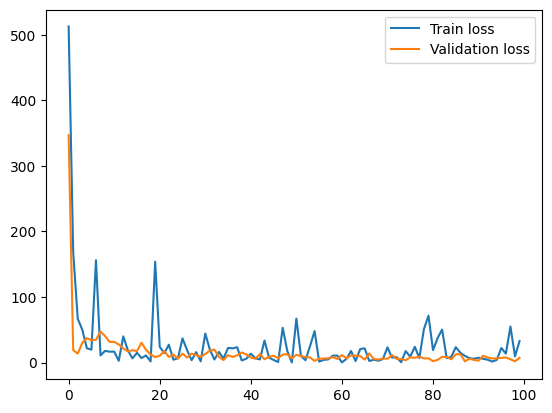

In [58]:
plt.figure()
plt.plot(train_loss,label= "Train loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend()
plt.show()

In [59]:
# Function to enable dropout during inference
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [60]:
preds = torch.zeros(100, 79)

for i in range(100):
  preds_ = torch.tensor([])
  for X, y in testloader:
      net.eval()
      enable_dropout(net)
      with torch.no_grad():
        out = net(X)
      preds_ = torch.cat((preds_, out.squeeze()))

  preds[i] = preds_



In [61]:

preds_mean = preds.mean(dim=0)
preds_std = preds.std(dim=0)


In [62]:
preds_upper = preds_mean + 2 * preds_std
preds_lower = preds_mean - 2 * preds_std

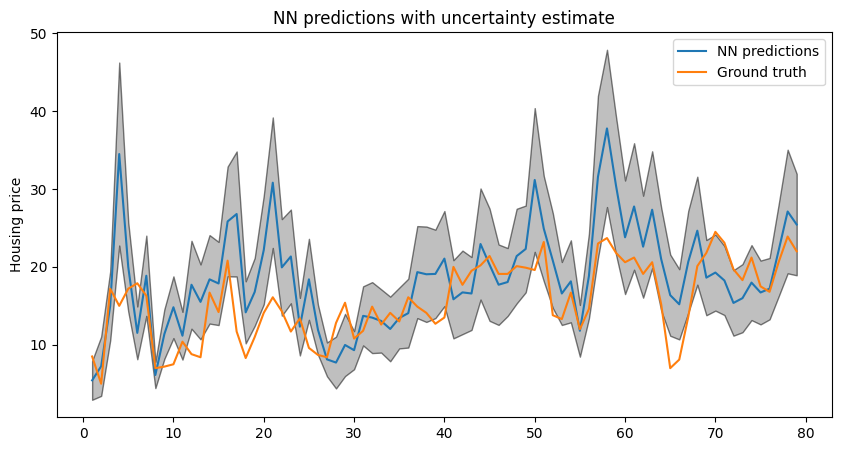

In [63]:
import numpy as np
x = np.arange(1,80,1)
plt.figure(figsize=(10, 5))
plt.title("NN predictions with uncertainty estimate")
plt.plot(x,preds_mean, label = "NN predictions")
plt.fill_between(x, preds_lower, preds_upper, alpha=0.5, edgecolor='k', facecolor='gray')
plt.plot(x, y_test, label = "Ground truth")
plt.ylabel("Housing price")
plt.legend()
plt.show()